In [162]:
# Khoruzhii Kirill, 30.05.2024
# Comments enhanced with the assistance of ChatGPT by OpenAI

In [340]:
import numpy as np

import scipy
from scipy import sparse

from IPython.display import clear_output

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired(np.linspace(0.1, 1, 12)))
dpi=100

The transverse field Ising model:
$$
H=-J \sum_{j=0}^{L-1} \sigma_j^x \sigma_{j+1}^x-g \sum_{j=0}^{L-1} \sigma_j^z
$$

## ed

In [404]:
Id = sparse.csr_matrix(np.eye(2))
Sx = sparse.csr_matrix([[0., 1.], [1., 0.]])
Sz = sparse.csr_matrix([[1., 0.], [0., -1.]])
Splus = sparse.csr_matrix([[0., 1.], [0., 0.]])
Sminus = sparse.csr_matrix([[0., 0.], [1., 0.]])


def singlesite_to_full(op, i, L):
    op_list = [Id]*L  # = [Id, Id, Id ...] with L entries
    op_list[i] = op
    full = op_list[0]
    for op_i in op_list[1:]:
        full = sparse.kron(full, op_i, format="csr")
    return full


def gen_sx_list(L):
    return [singlesite_to_full(Sx, i, L) for i in range(L)]


def gen_sz_list(L):
    return [singlesite_to_full(Sz, i, L) for i in range(L)]


def gen_hamiltonian_periodic(sx_list, sz_list, g, J=1.):
    """ assumes periodic boundery conditions """
    L = len(sx_list)
    H = sparse.csr_matrix((2**L, 2**L))
    for j in range(L):
        H = H - J *( sx_list[j] * sx_list[(j+1)%L])
        H = H - g * sz_list[j]
    return H


def gen_hamiltonian(sx_list, sz_list, g, J=1.):
    """ assumes open boundery conditions """
    L = len(sx_list)
    H = sparse.csr_matrix((2**L, 2**L))
    for j in range(L-1):
        H = H - J *( sx_list[j] * sx_list[(j+1)%L])
        H = H - g * sz_list[j]
    H = H - g * sz_list[-1]
    return H

## ed_conserve

In [269]:
"""Exact diagonalization code for the transverse field Ising model with momentum conservation.

H = -J sum_i sigma^x_i sigma^x_{i+1} - g sum_i sigma^z i; periodic boundary cond.

"""

def flip(s, i, N):
    """Flip the bits of the state `s` at positions i and (i+1)%N."""
    return s ^ (1 << i | 1 << ((i+1) % N))


def translate(s, N):
    """Shift the bits of the state `s` one position to the right (cyclically for N bits)."""
    bs = bin(s)[2:].zfill(N)
    return int(bs[-1] + bs[:-1], base=2)


def count_ones(s):
    """Count the number of `1` in the binary representation of the state `s`."""
    return bin(s).count('1')


def is_representative(s, k, N):
    """Check if |s> is the representative for the momentum state.

    Returns -1 if s is not a representative.
    If |s> is a representative, return the periodicity R,
    i.e. the smallest integer R > 0 such that T**R |s> = |s>."""
    t = s
    for i in range(N):
        t = translate(t, N)
        if t < s:
            return -1  # there is a smaller representative in the orbit
        elif (t == s):
            if (np.mod(k, N/(i+1)) != 0):
                return -1  # periodicty incompatible with k
            else:
                return i+1


def get_representative(s, N):
    """Find the representative r in the orbit of s and return (r, l) such that |r>= T**l|s>"""
    r = s
    t = s
    l = 0
    for i in range(N):
        t = translate(t, N)
        if (t < r):
            r = t
            l = i + 1
    return r, l


def calc_basis(N):
    """
    Determine the representatives and their indices for the basis of each block in the Hamiltonian.

    This function generates the basis states for the transverse field Ising model Hamiltonian,
    grouped by their quantum number k, which corresponds to the conserved momentum. The function
    considers all possible binary configurations of N spins and identifies their representatives
    to minimize redundancy due to symmetries.

    Parameters:
    - N (int): The number of spins in the system.

    Returns:
    - basis (dict): A dictionary where keys are quantum numbers (k values), and values are lists
      of tuples. Each tuple contains a representative state `sa` and its periodicity `Ra`.
    - ind_in_basis (dict): A dictionary mapping each quantum number `k` to another dictionary,
      which maps each representative state `sa` to its index in the `basis[k]` list.

    Each basis state `sa` is associated with a periodicity `Ra`, which is the smallest number
    of translations needed to recover the state. This periodicity is essential for constructing
    the Hamiltonian matrix elements correctly.
    """
    basis = dict()          # Dictionary to hold the basis states for each quantum number k
    ind_in_basis = dict()   # Dictionary to map each state to its index in the basis list

    # Loop over all possible states of the system (2^N possible states for N spins)
    for sa in range(2**N):
        # Loop over possible values of the quantum number k
        for k in range(-N//2 + 1, N//2 + 1):
            qn = k  # Quantum number k
            Ra = is_representative(sa, k, N)  # Determine if the state `sa` is a representative for this k

            # If `sa` is a representative, then include it in the basis
            if Ra > 0:  # Check if the state is indeed a representative
                if qn not in basis:
                    basis[qn] = []           # Initialize the list of basis states for this quantum number
                    ind_in_basis[qn] = {}    # Initialize the index mapping for this quantum number

                # Map the state `sa` to its index in the list and add it to the basis
                ind_in_basis[qn][sa] = len(basis[qn])
                basis[qn].append((sa, Ra))  # Append the state and its periodicity

    return basis, ind_in_basis



def calc_H(N, J, g):
    """
    Determine the blocks of the Hamiltonian as scipy.sparse.csr_matrix.

    Parameters:
    - N (int): The number of spins in the system.
    - J (float): Coupling constant for the interaction between spins.
    - g (float): Magnetic field strength in the z-direction.

    Returns:
    - H (dict): A dictionary where each key is a momentum quantum number 'k',
      and the value is a sparse matrix representing the Hamiltonian block for that k.
    """
    print("Generating Hamiltonian ... ", end="", flush=True)
    basis, ind_in_basis = calc_basis(N)  # Calculate basis and their indices for each momentum block
    H = {}  # Dictionary to store Hamiltonian blocks for each k value

    for qn in basis:
        M = len(basis[qn])  # Number of states in the basis for quantum number qn
        H_block_data = []  # List to store non-zero values in the Hamiltonian block
        H_block_inds = []  # List to store the indices of non-zero values

        a = 0  # Index of state in the Hamiltonian matrix
        for sa, Ra in basis[qn]:  # Loop over each state and its periodicity in the basis
            # Diagonal element calculation:
            # -g * (-N + 2*count_ones(sa)) gives the contribution from sigma^z terms
            H_block_data.append(-g * (-N + 2 * count_ones(sa)))
            H_block_inds.append((a, a))

            # Off-diagonal elements due to flipping spins:
            for i in range(N):
                sb, l = get_representative(flip(sa, i, N), N)  # Flip spins and find the representative state
                if sb in ind_in_basis[qn]:
                    b = ind_in_basis[qn][sb]  # Get index of the flipped state
                    Rb = basis[qn][b][1]  # Get periodicity of the flipped state
                    k = qn * 2 * np.pi / N  # Convert quantum number to actual momentum value
                    # -J * exp(-1j * k * l) * sqrt(Ra / Rb) adds the interaction term contribution
                    H_block_data.append(-J * np.exp(-1j * k * l) * np.sqrt(Ra / Rb))
                    H_block_inds.append((b, a))

            a += 1  # Increment the state index

        # Convert lists to numpy arrays for use in sparse matrix constructor
        H_block_inds = np.array(H_block_inds)
        H_block_data = np.array(H_block_data)
        # Create a sparse matrix for this block of the Hamiltonian
        H_block = scipy.sparse.csr_matrix((H_block_data, (H_block_inds[:, 0], H_block_inds[:, 1])), shape=(M, M), dtype=complex)
        H[qn] = H_block  # Store the block in the dictionary

    print("done", flush=True)
    return H

## Exact diagonalization with quantum numbers

In [213]:
# a)
H = calc_H(N=10, J=1, g=0.1)

E0 = sparse.linalg.eigsh(H[0], 1, which='SA')[0][0]
print(f"E_0  = {E0:.13f}")

Generating Hamiltonian ... done
E_0  = -10.0250156642343


In [214]:
# b) This one is a little faster: 9.2s instead 15s for calc_H(N=16)

%timeit translate(10**6, 10**3)

def translate(s, N):
    """Shift the bits of the state `s` one position to the right (cyclically for N bits) with bitwise operations"""
    return ((s << 1) | (s >> (N - 1))) & ((1 << N) - 1)

%timeit translate(10**6, 10**3)

3.41 µs ± 0.442 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
264 ns ± 46.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


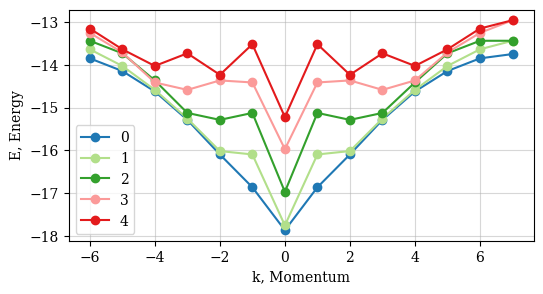

In [342]:
# c)
H = calc_H(N=14, J=1, g=1); clear_output();

n = 5;
ks = sorted(H.keys());
Es = np.zeros((len(ks), n));
for (j, k) in enumerate(ks):
    Es[j] = sparse.linalg.eigsh(H[k], 5, which='SA')[0]
    
plt.figure(figsize=(6, 3), dpi=dpi)
plt.plot(ks, Es, "-o", label=range(5))
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('k, Momentum')
plt.ylabel('E, Energy')
plt.show()

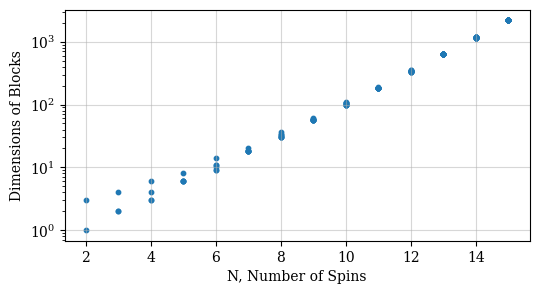

In [343]:
# d)
fig, ax = plt.subplots(figsize=(6, 3), dpi=dpi)
for N in range(2, 16):
    print(N)
    clear_output(wait=True) 
    basis, _ = calc_basis(N)
    basis = dict(sorted(basis.items())) #sort by k
    dims = [len(b) for b in basis.values()]
    ax.set_prop_cycle(None)
    ax.scatter([N] * len(dims), dims, s=10)

ax.set_yscale("log")
plt.xlabel('N, Number of Spins')
plt.ylabel('Dimensions of Blocks')
plt.grid(alpha=0.5)
plt.show()

In [354]:
# e)

def parity(s):
    """Calculate the parity of a given spin configuration.
    Parity is (-1)^(number of bits set to 1 in the binary representation of s).

    Args:
    s (int): The spin configuration as an integer.

    Returns:
    int: The parity eigenvalue (+1 or -1).
    """    
    return (-1) ** count_ones(s)


def calc_basis_parity(N):
    """Determine the (representatives of the) basis for each block with both momentum and parity.

    Args:
    N (int): The number of spins in the system.

    Returns:
    dict: A dictionary of basis states indexed by (parity, momentum).
    """
    basis = dict()
    ind_in_basis = dict()
    for sa in range(2**N):
        p = parity(sa)  # Calculate the parity of the state
        for k in range(-N//2 + 1, N//2 + 1):
            qn = (p, k)  # Quantum number now includes both parity and momentum
            Ra = is_representative(sa, k, N)
            if Ra > 0:
                if qn not in basis:
                    basis[qn] = []
                    ind_in_basis[qn] = dict()
                ind_in_basis[qn][sa] = len(basis[qn])
                basis[qn].append((sa, Ra))
    return basis, ind_in_basis



def calc_H_parity(N, J, g):
    """Determine the blocks of the Hamiltonian.
    
    Args:
    N (int): Number of spins
    J (float): Coupling
    g (float): Magnetic field

    Returns:
    dict: Hamiltonian blocks keyed by (parity, momentum).
    """
    basis, ind_in_basis = calc_basis_parity(N)
    H = {}
    for qn in basis:
        M = len(basis[qn])
        H_block_data = []
        H_block_inds = []
        for (a, (sa, Ra)) in enumerate(basis[qn]):
            H_block_data.append(-g * (-N + 2 * count_ones(sa)))
            H_block_inds.append((a, a))
            for i in range(N):
                sb, l = get_representative(flip(sa, i, N), N)
                if sb in ind_in_basis[qn]:
                    b = ind_in_basis[qn][sb]
                    Rb = basis[qn][b][1]
                    k_phase = np.exp(-1j * qn[1] * l * 2 * np.pi / N)
                    H_block_data.append(-J * k_phase * np.sqrt(Ra / Rb))
                    H_block_inds.append((b, a))
        H_block_inds = np.array(H_block_inds)
        H_block_data = np.array(H_block_data)
        H_block = scipy.sparse.csr_matrix((H_block_data, (H_block_inds[:, 0], H_block_inds[:, 1])), shape=(M,M))
        H[qn] = H_block
    return H

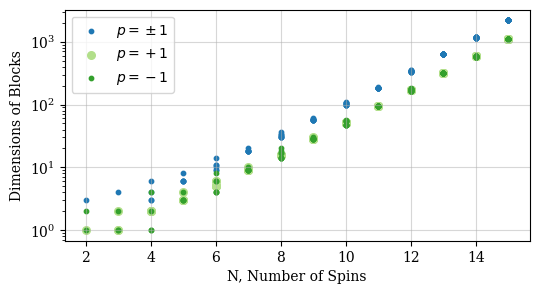

In [357]:
# f)
Ns = np.arange(2, 16)


fig, ax = plt.subplots(figsize=(6, 3), dpi=dpi)
for N in Ns:
    print(N)
    clear_output(wait=True) 

    basis, _ = calc_basis(N)
    dims_full = [len(b) for b in basis.values()]
    
    basis_p, _ = calc_basis_parity(N)
    basis_p = dict(sorted(basis_p.items())) #sort by p,k
    dims = [len(b) for b in basis_p.values()]
    dims_p_negative = dims[:len(dims)//2]
    dims_p_positive = dims[len(dims)//2:]
    ax.set_prop_cycle(None)
    if N==Ns[0]:
        ax.scatter([N] * len(dims_full), dims_full, s=10, label="$p = \\pm 1$")
        ax.scatter([N] * len(dims_p_negative), dims_p_negative, s=30, label="$p = + 1$")
        ax.scatter([N] * len(dims_p_positive), dims_p_positive, s=10, label="$p = - 1$")
    else:
        ax.scatter([N] * len(dims_full), dims_full, s=10)
        ax.scatter([N] * len(dims_p_negative), dims_p_negative, s=30)
        ax.scatter([N] * len(dims_p_positive), dims_p_positive, s=10)
        

ax.set_yscale("log")
plt.xlabel('N, Number of Spins')
plt.ylabel('Dimensions of Blocks')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [370]:
# g)
N=14
J=1
g=1

H = calc_H_parity(N=N, J=J, g=g)
n = 5
ks = np.arange(-N//2+1, N//2+1, 1)
Es_positive = np.zeros((N, n))
Es_negative = np.zeros((N, n))
for p in [-1, +1]:
    for (j, k) in enumerate(ks):
        if p > 0:
            Es_positive[j] = sparse.linalg.eigsh(H[(p, k)], 5, which='SA')[0]
        else:
            Es_negative[j] = sparse.linalg.eigsh(H[(p, k)], 5, which='SA')[0]

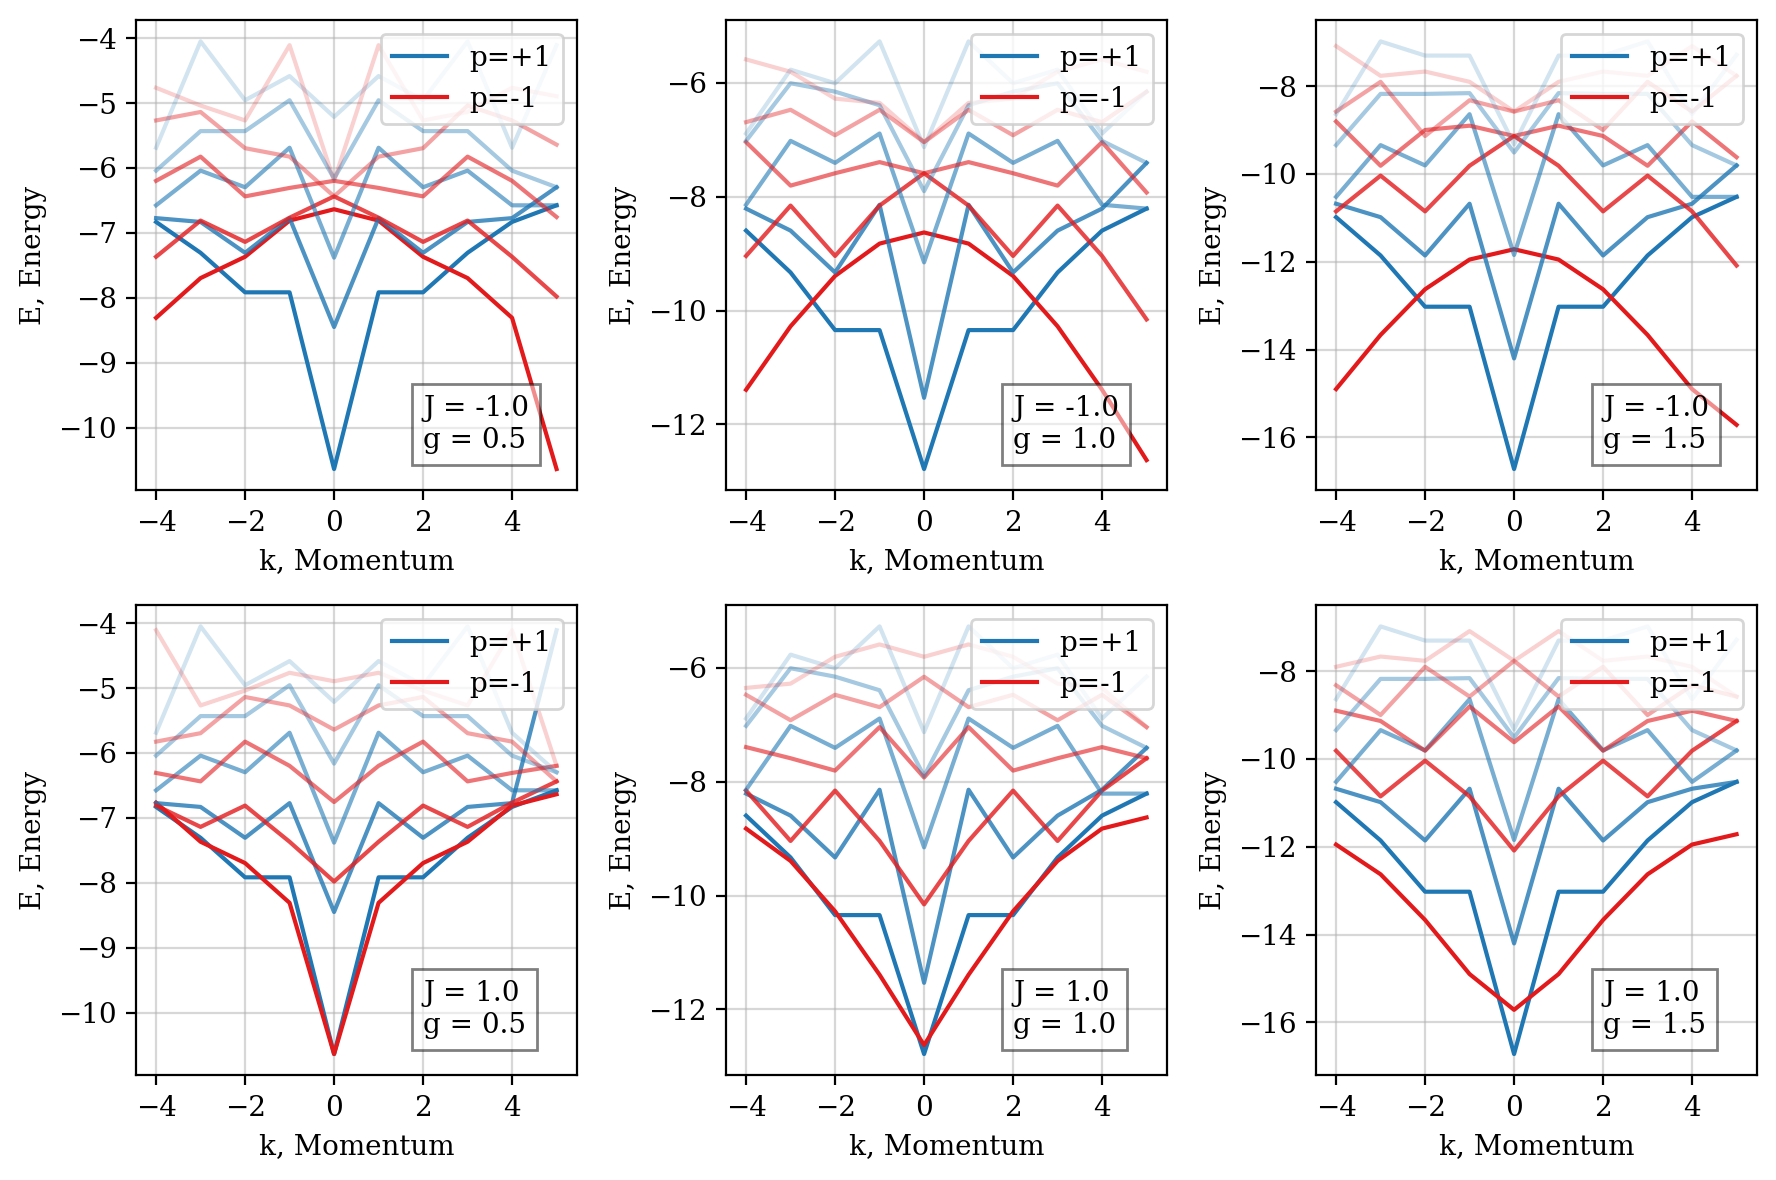

In [403]:
N = 10        
n = 5

fig, axs = plt.subplots(2, 3, figsize=(9, 6), dpi=2*dpi);
for (x, J) in enumerate([-1, 1]):
    for (y, g) in enumerate([0.5, 1, 1.5]):
        ax = axs[x, y]
        
        H = calc_H_parity(N=N, J=J, g=g)
        ks = np.arange(-N//2+1, N//2+1, 1)
        Es_positive = np.zeros((N, n))
        Es_negative = np.zeros((N, n))
        for p in [-1, +1]:
            for (j, k) in enumerate(ks):
                if p > 0:
                    Es_positive[j] = sparse.linalg.eigsh(H[(p, k)], 5, which='SA')[0]
                else:
                    Es_negative[j] = sparse.linalg.eigsh(H[(p, k)], 5, which='SA')[0]
        
        for j in range(n):
            if j==0:
                ax.plot(ks, Es_positive[:, j], "-", color=plt.cm.Paired(0.1), alpha=1-j/n, label="p=+1")
                ax.plot(ks, Es_negative[:, j], "-", color=plt.cm.Paired(0.45), alpha=1-j/n, label="p=-1")
            else:
                ax.plot(ks, Es_positive[:, j], "-", color=plt.cm.Paired(0.1), alpha=1-j/n)
                ax.plot(ks, Es_negative[:, j], "-", color=plt.cm.Paired(0.45), alpha=1-j/n)
        ax.grid(alpha=0.5)
        ax.set_xlabel('k, Momentum')
        ax.set_ylabel('E, Energy')

        Es = np.concatenate((Es_positive, Es_negative))
        ax.text(2, np.min(Es) + 0.05 * (np.max(Es) - np.min(Es)), f'J = {J:.1f}\ng = {g:.1f}', fontsize=10, color='black',
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 4, 'edgecolor': 'black'})
        ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

Indeed, we see that when the magnetic field is less than critical, the energy of the ground state becomes degenerate. Also, with antiferomagnetic interaction, the dispersion for the even and odd states changes significantly.

## Area law - ground state versus random state

In [481]:
def get_ground_state(L, g, J=1.0):
    # Generate lists of sigma-x and sigma-z operators for all spins
    sx_list = gen_sx_list(L)
    sz_list = gen_sz_list(L)

    # Generate the Hamiltonian for the system
    H = gen_hamiltonian(sx_list, sz_list, g, J)

    # Compute the lowest eigenvalue and corresponding eigenvector of the Hamiltonian
    E, gs = scipy.sparse.linalg.eigsh(H, k=1, which='SA')

    # Return the ground state eigenvector
    return gs

In [493]:
# a)
L = 14
g = 1.5

gs = get_ground_state(L, g)
print(f'Hilber space dim = {gs.shape[0]}')


basis = np.zeros((2**L, L), dtype=np.int32)
for j in range(2**L):
    basis[j] = np.array(list(bin(j)[2:].zfill(L)), dtype=np.int32)
    
# mean spin on each cite
np.round(np.sum((np.abs(gs)**2 * basis), axis=0), 2)

Hilber space dim = 16384


array([0.03, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06,
       0.06, 0.06, 0.03])

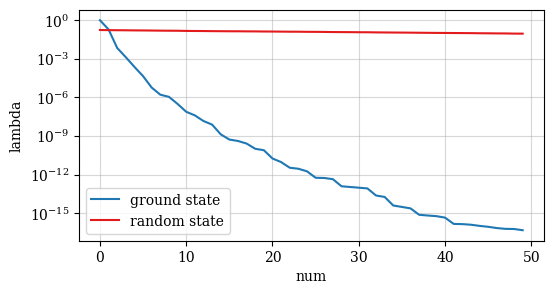

In [494]:
# b)
L = 14
psi_ab = np.reshape(gs, (2**(L//2), 2**(L//2)))

# c)
def get_schmidt_values(state, reshape_flag=False):
    """
    Compute and return the Schmidt decomposition singular values of a quantum state.
    
    Args:
    state (np.array): The quantum state represented as a matrix or a flattened array.
    reshape_flag (bool): If True, the state is reshaped into a square matrix before decomposition.

    Returns:
    np.array: An array of singular values sorted in descending order.
    """
    if reshape_flag:
        # Reshape the state into a square matrix if indicated by the reshape_flag
        state = np.reshape(state, (2**(L//2), 2**(L//2)))
    _, s, _ = scipy.linalg.svd(state, lapack_driver='gesvd')
    
    # Sort the singular values in descending order before returning
    return -np.sort(-s)

# d, e)
def get_random_state(L):
    re = np.random.normal(0, 1, 2**L)
    im = np.random.normal(0, 1, 2**L)
    random_state = re + 1j * im
    random_state /= np.linalg.norm(random_state)
    return random_state

sv_gs   = get_schmidt_values(gs, True)
sv_haar = get_schmidt_values(get_random_state(14), True)


fig, ax = plt.subplots(figsize=(6, 3), dpi=dpi)
ax.plot(sv_gs[:50], label="ground state")
ax.plot(sv_haar[:50], label="random state", color=plt.cm.Paired(0.45))
ax.grid(alpha=0.5)
ax.set_yscale("log")
ax.set_xlabel("num")
ax.set_ylabel("lambda")
plt.legend()
plt.show()

Conclusion: random tensors are poorly compressed, it’s great that the states we need are not random!

![](https://i.pinimg.com/736x/df/48/ce/df48ce661b80e256ff1606ca9e40cd42.jpg)

In [495]:
# f)

def get_entanglement_entropy(state):
    """
    Calculate the entanglement entropy of a quantum state.

    Args:
    state (np.array): The quantum state from which to calculate the entanglement entropy.

    Returns:
    float: The calculated entanglement entropy of the state.
    """
    # Get Schmidt coefficients from the state, squared to obtain probabilities
    probabilities = get_schmidt_values(state, True)**2
    
    # Compute the entanglement entropy using the entropy formula
    return -np.sum(probabilities * np.log(probabilities))

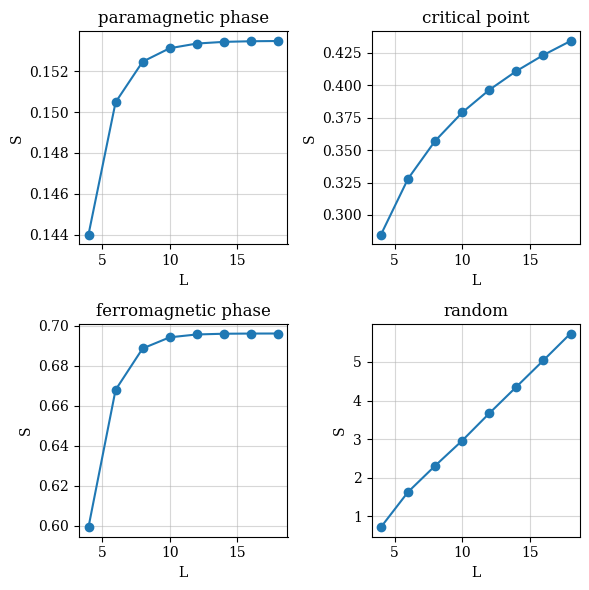

In [500]:
# g)

labels = [
    "paramagnetic phase",
    "critical point",
    "ferromagnetic phase"
]
gs = [1.5, 1.0, 0.5]
Ls = np.arange(4, 20, 2)

fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=dpi)
for (i, (g, label)) in enumerate(zip(gs, labels)):
    Ss = np.zeros(len(Ls))
    for (j, L) in enumerate(Ls):
        Ss[j] = get_entanglement_entropy(get_ground_state(L, g))
    ax = axs.flatten()[i]
    ax.plot(Ls, Ss, "-o")
    ax.set_title(label)

ax = axs.flatten()[3]
Ss = np.zeros(len(Ls))
for (j, L) in enumerate(Ls):
    Ss[j] = get_entanglement_entropy(get_random_state(L))
ax.plot(Ls, Ss, "-o")
ax.set_title("random")
    
for ax in axs.flatten():
    ax.grid(alpha=0.5)
    ax.set_xlabel("L")
    ax.set_ylabel("S")
plt.tight_layout()
plt.show()

Indeed, in the AFM phase, the ground state is non-degenerate, there is a gap, so the low-energy states are weakly entangled. However, for the FM phase, the ground state is already degenerate, there is no gap, and the entanglement is higher, although it still does not reach the level of a random state. Interestingly, I see saturation in individual phases, but not at the critical point. In fact, for a random state, the entanglement entropy turns out to be proportional to the size of the system.